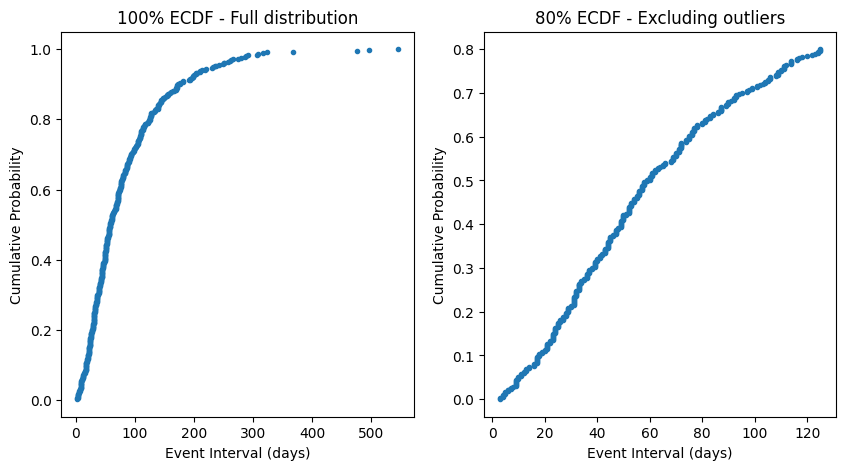

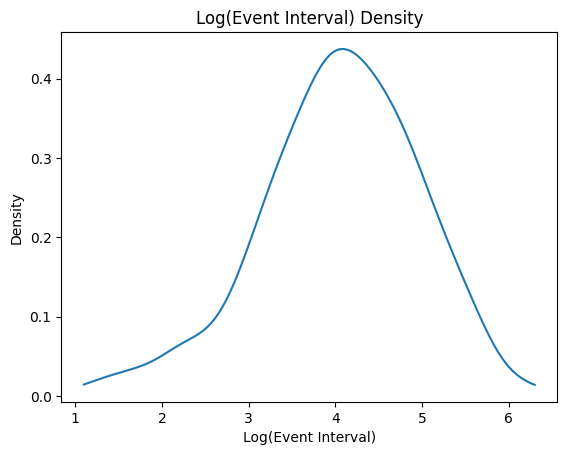

Silhouette Score for Cluster_KMeans: 0.5502924178027989
Cannot calculate Silhouette Score for Cluster_DBSCAN: Only 1 unique labels found.
K-Means Cluster Summary:
                count        mean        std    min    25%    50%    75%  \
Cluster_KMeans                                                             
0                66.0   33.530303   4.095850   27.0   31.0   33.0   37.0   
1                45.0  176.177778  23.416475  143.0  156.0  172.0  198.0   
2                23.0   10.391304   2.083248    7.0    9.0   10.0   12.0   
3                77.0   78.610390   8.574988   64.0   72.0   77.0   87.0   
4                48.0   21.187500   3.166690   16.0   18.0   21.5   24.0   
5                25.0  301.280000  83.947166  231.0  251.0  275.0  308.0   
6                11.0    4.636364   1.120065    3.0    4.0    5.0    5.5   
7                63.0  117.142857  12.979956   97.0  107.0  114.0  127.0   
8                91.0   51.769231   6.062777   42.0   47.0   52.0   57.0   



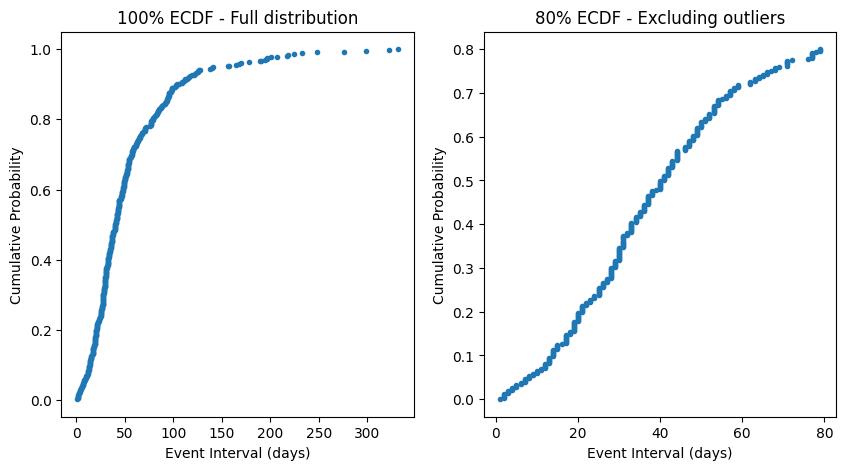

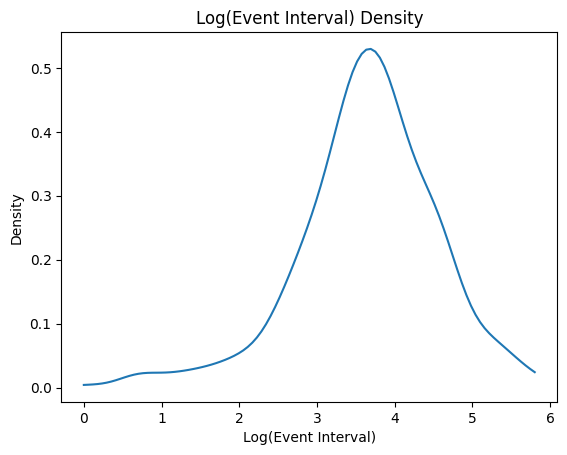

Silhouette Score for Cluster_KMeans: 0.5681592260766506
Silhouette Score for Cluster_DBSCAN: 0.7022999726798326
K-Means Cluster Summary:
                count        mean        std    min    25%    50%     75%  \
Cluster_KMeans                                                              
0               120.0   50.600000   7.851992   40.0   44.0   49.0   56.00   
1                24.0    8.708333   2.457980    5.0    7.0    8.5   11.00   
2                77.0   93.753247  15.890378   69.0   81.0   93.0  103.00   
3               108.0   31.212963   4.037328   24.0   28.0   31.0   34.25   
4                12.0    2.666667   0.984732    1.0    2.0    2.5    3.25   
5                63.0   17.873016   2.981080   13.0   15.0   19.0   20.00   
6                25.0  206.200000  53.895733  138.0  168.0  197.0  224.00   

                  max  
Cluster_KMeans         
0                68.0  
1                12.0  
2               127.0  
3                39.0  
4                 4.0  
5

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from scipy.stats import gaussian_kde
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score

# Load dataset
med_events = pd.read_csv("../data/med_events.csv")
med_events.columns = ["pnr", "eksd", "perday", "ATC", "dur_original"]
med_events["eksd"] = pd.to_datetime(med_events["eksd"], format="%m/%d/%Y")

def compute_event_intervals(data):
    """Calculate event intervals for medication use."""
    data.sort_values(by=["pnr", "eksd"], inplace=True)
    data["prev_eksd"] = data.groupby("pnr")["eksd"].shift(1)
    data.dropna(inplace=True)
    data["event_interval"] = (data["eksd"] - data["prev_eksd"]).dt.days
    return data[data["event_interval"] > 0]

def plot_ecdf(data):
    """Generate ECDF plots."""
    ecdf_x = np.sort(data["event_interval"].values)
    ecdf_y = np.arange(1, len(ecdf_x) + 1) / len(ecdf_x)
    threshold = np.percentile(ecdf_x, 80)
    filtered_x = ecdf_x[ecdf_x <= threshold]
    filtered_y = np.linspace(0, 0.8, len(filtered_x))
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(ecdf_x, ecdf_y, marker=".", linestyle="none")
    plt.title("100% ECDF - Full distribution")
    plt.xlabel("Event Interval (days)")
    plt.ylabel("Cumulative Probability")
    
    plt.subplot(1, 2, 2)
    plt.plot(filtered_x, filtered_y, marker=".", linestyle="none")
    plt.title("80% ECDF - Excluding outliers")
    plt.xlabel("Event Interval (days)")
    plt.ylabel("Cumulative Probability")
    plt.show()

def plot_density(data):
    """Generate density plot of log-transformed event intervals."""
    log_intervals = np.log(data["event_interval"])
    density = gaussian_kde(log_intervals)
    x_vals = np.linspace(min(log_intervals), max(log_intervals), 100)
    
    plt.figure()
    plt.plot(x_vals, density(x_vals))
    plt.title("Log(Event Interval) Density")
    plt.xlabel("Log(Event Interval)")
    plt.ylabel("Density")
    plt.show()

def perform_kmeans_clustering(data):
    """Apply K-Means clustering and return cluster assignments."""
    log_intervals = np.log(data["event_interval"]).values.reshape(-1, 1)
    best_clusters, best_score = 2, -1
    for k in range(2, 10):
        km = KMeans(n_clusters=k, random_state=1234)
        labels = km.fit_predict(log_intervals)
        score = silhouette_score(log_intervals, labels)
        if score > best_score:
            best_clusters, best_score = k, score
    
    km = KMeans(n_clusters=best_clusters, random_state=1234)
    data.loc[:, "Cluster_KMeans"] = km.fit_predict(log_intervals)
    return data

def perform_dbscan_clustering(data):
    """Apply DBSCAN clustering as an alternative to K-Means."""
    log_intervals = np.log(data["event_interval"]).values.reshape(-1, 1)
    db = DBSCAN(eps=0.5, min_samples=5).fit(log_intervals)
    data.loc[:, "Cluster_DBSCAN"] = db.labels_
    return data

def plot_silhouette_analysis(data, cluster_col):
    """Generate silhouette analysis plot."""
    log_intervals = np.log(data["event_interval"]).values.reshape(-1, 1)
    labels = data[cluster_col].values
    
    # Ensure at least two unique clusters for silhouette score
    unique_labels = np.unique(labels)
    if len(unique_labels) < 2:
        print(f"Cannot calculate Silhouette Score for {cluster_col}: Only {len(unique_labels)} unique labels found.")
        return
    
    score = silhouette_score(log_intervals, labels)
    print(f"Silhouette Score for {cluster_col}: {score}")

def cluster_summary(data, cluster_col):
    """Generate cluster summary statistics."""
    return data.groupby(cluster_col)["event_interval"].describe()

def analyze_medication(arg1):
    """Complete pipeline for Sessa Empirical Estimator using K-Means and DBSCAN."""
    data = med_events[med_events["ATC"] == arg1].copy()
    data = compute_event_intervals(data)
    if data.empty:
        print("No valid intervals found.")
        return None
    
    plot_ecdf(data)
    plot_density(data)
    
    data = perform_kmeans_clustering(data)
    data = perform_dbscan_clustering(data)
    
    plot_silhouette_analysis(data, "Cluster_KMeans")
    plot_silhouette_analysis(data, "Cluster_DBSCAN")
    
    print("K-Means Cluster Summary:")
    print(cluster_summary(data, "Cluster_KMeans"))
    print("DBSCAN Cluster Summary:")
    print(cluster_summary(data, "Cluster_DBSCAN"))
    
    return data

# Example Calls
medA = analyze_medication("medA")
medB = analyze_medication("medB")
